We will use this dataset for this task:
https://www.kaggle.com/datasets/atulanandjha/temperature-readings-iot-devices

In [1]:
import os
os.system('cmd /c "pip install -q numpy pandas matplotlib"') # On the assumption that Pip is used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We first import the dataset into a dataframe with Pandas and let's have a look at the first rows

In [2]:
df = pd.read_csv('IOT-temp.csv', na_filter=False)
with pd.option_context('expand_frame_repr', False):
    print (df)

                                        id  room_id/id        noted_date  temp out/in
0      __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29     In
1      __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29     In
2      __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41    Out
3      __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41    Out
4      __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31     In
...                                    ...         ...               ...   ...    ...
97601   __export__.temp_log_91076_7fbd08ca  Room Admin  28-07-2018 07:07    31     In
97602  __export__.temp_log_147733_62c03f31  Room Admin  28-07-2018 07:07    31     In
97603  __export__.temp_log_100386_84093a68  Room Admin  28-07-2018 07:06    31     In
97604  __export__.temp_log_123297_4d8e690b  Room Admin  28-07-2018 07:06    31     In
97605  __export__.temp_log_133741_32958703  Room Admin

So we can see a lot of problems with each column:

- id: Probably useless for any data analytics task
- room_id/id: Looks like this column only has the value 'Room Admin' - needs further verification
- noted_date: Now we want to change noted_date to a number as a date cannot be fed into a model
- temp: We probably want a decimal number for temperature, but this is an integer
- out/in: By the looks of the data it seems like there are more 'in' than 'out', have to validate!

Let's try to remove these problems now, starting with removing `id` first!

In [3]:
df = df.drop(['id'], axis=1) # Removes the ID Column
print (df)

       room_id/id        noted_date  temp out/in
0      Room Admin  08-12-2018 09:30    29     In
1      Room Admin  08-12-2018 09:30    29     In
2      Room Admin  08-12-2018 09:29    41    Out
3      Room Admin  08-12-2018 09:29    41    Out
4      Room Admin  08-12-2018 09:29    31     In
...           ...               ...   ...    ...
97601  Room Admin  28-07-2018 07:07    31     In
97602  Room Admin  28-07-2018 07:07    31     In
97603  Room Admin  28-07-2018 07:06    31     In
97604  Room Admin  28-07-2018 07:06    31     In
97605  Room Admin  28-07-2018 07:06    31     In

[97606 rows x 4 columns]


Now let's see if our hypothesis on room_id/id is correct

In [4]:
room_id = set(df['room_id/id'])
print (room_id)

{'Room Admin'}


As we can see the column `room_id/id` only has one element, so we can remove that column as it is not useful

In [5]:
df = df.drop(['room_id/id'], axis=1)
print (df)

             noted_date  temp out/in
0      08-12-2018 09:30    29     In
1      08-12-2018 09:30    29     In
2      08-12-2018 09:29    41    Out
3      08-12-2018 09:29    41    Out
4      08-12-2018 09:29    31     In
...                 ...   ...    ...
97601  28-07-2018 07:07    31     In
97602  28-07-2018 07:07    31     In
97603  28-07-2018 07:06    31     In
97604  28-07-2018 07:06    31     In
97605  28-07-2018 07:06    31     In

[97606 rows x 3 columns]


We can see that some 'noted_date' are repeated even with the same 'out/in' column value.  We need to merge the duplicated data as well as changing the datatype of values, i.e. noted_date from dates to numbers, and temperature to a decimal number

In [6]:
df_list = np.append(df.values, np.ones((df.values.shape[0], 1)), axis=1)
dup_removed = [df_list[0].tolist()]
for i in range(1, df_list.shape[0]):
    if dup_removed[-1][0] == df_list[i][0] and dup_removed[-1][2] == df_list[i][2]:
        dup_removed[-1][1] += df_list[i][1]
        dup_removed[-1][3] += 1
    else:
        dup_removed.append(df_list[i].tolist())
dup_removed = np.array([[i[0], i[1]/i[3], i[2]] for i in dup_removed])
df = pd.DataFrame(dup_removed, columns=list(df))

df['noted_date'] = pd.to_numeric(pd.to_datetime(df['noted_date'], format='%d-%m-%Y %H:%M'))
df['temp'] = pd.to_numeric(df['temp'])
print (df)

                noted_date  temp out/in
0      1544261400000000000  29.0     In
1      1544261340000000000  41.0    Out
2      1544261340000000000  31.0     In
3      1544261280000000000  29.0     In
4      1544261160000000000  29.0     In
...                    ...   ...    ...
38706  1532761620000000000  32.0    Out
38707  1532761620000000000  31.0     In
38708  1532761620000000000  32.0    Out
38709  1532761620000000000  31.0     In
38710  1532761560000000000  31.0     In

[38711 rows x 3 columns]


Now we should rescale `noted_date` to values from 0 to 1, or in general scale it down.

In [7]:
df['noted_date'] = (df['noted_date'] - min(df['noted_date'])) / (max(df['noted_date']) - min(df['noted_date']))
print (df)

       noted_date  temp out/in
0        1.000000  29.0     In
1        0.999995  41.0    Out
2        0.999995  31.0     In
3        0.999990  29.0     In
4        0.999979  29.0     In
...           ...   ...    ...
38706    0.000005  32.0    Out
38707    0.000005  31.0     In
38708    0.000005  32.0    Out
38709    0.000005  31.0     In
38710    0.000000  31.0     In

[38711 rows x 3 columns]


We can investigate the frequency of in and out in the column 'out/in' after shrinking the dataframe.

In [8]:
from collections import Counter
print (Counter(df['out/in']))

Counter({'Out': 26484, 'In': 12227})


We can now see the distribution of 'temp' and 'noted_date'

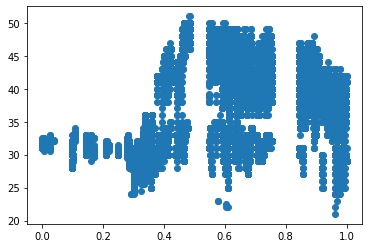

In [9]:
plt.scatter(df['noted_date'], df['temp'])